In [175]:
#! pip install torch

In [1]:
import torch
import numpy as np
from rect_grid import Node, GridStructure
import solve_linear as sl
import torch
import torch.nn as nn
import math
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import copy

### The below is the class for square neural network. It consists of all the functions and matrices needed to train the model.

#### The only trainable parameters are Beta and W1. Not all elements of Beta and W1 are trainable. Only those elements where the mask (W1_mask or W2_fixed_mask) is False are trainable.
Few Things to Keep Note of:
- _initialize_W1_blocks() initializes both W1 and W1_fixed. This W1 is not the same W1 that we use to obtain the hidden layer by multiplying with the input. The matrix that performs the multiplication is defined in the forward() function. W1_dynamic and W2_dynamic are the matrices that uses torch.where() to select both the fixed values and trainable parameters.
- _initialize_W2() initializes Beta and W2_fixed in 3 different steps. The first step is to initialize the value in the top half of the rightmost (n^2+4n by 4n) sub matrix. The second part deals with the diagonals and the third part assigns the value of 1 to the bottom left sub matrix to copy the Neumann data to the final layer for proper subtraction.
- symmetrize_W2_after_training is used to ensure that before every forward pass, our matrices, especially W2_dynamic will be with proper values and constraints

In [104]:
# Define the neural network architecture for rectangular network
class SquareEITNN(nn.Module):
    def __init__(self, grid):
        super(SquareEITNN, self).__init__()
        self.grid = grid
        self.n = grid.n
        self.input_size = 8 * self.n
        self.hidden_size = self.n **2 + 8* self.n
        self.output_size = self.n **2 + 4* self.n
        self.interior_size = self.n **2
        self.neumann_copy_start = self.n **2 +4*self.n


        # Initialize W1 as a single Parameter matrix
        self.W1 = nn.Parameter(torch.zeros(self.hidden_size, self.input_size, dtype = torch.float64, requires_grad = True))
        self.W1_fixed = torch.zeros(self.hidden_size, self.input_size, dtype=torch.float64)
        # W1_fixed_mask: True means fixed (non-trainable), False means trainable
        self.W1_fixed_mask = torch.ones(self.hidden_size, self.input_size, dtype=torch.bool)
        self.W1_fixed_mask[:self.interior_size, :4*self.n] = False  # Make top left n^2 by 4n matrix trainable

        # self.register_buffer('W1_mask', (~self.W1_fixed_mask).float())


        self._initialize_W1_blocks()
        self._initialize_W2()
        # self.store_original()

    def _initialize_W1_blocks(self):
        # A: random positive (n^2 by 4n)
        #Xavier initialization
        with torch.no_grad():
            self.W1[:self.interior_size, :4*self.n] = torch.randn(self.interior_size, 4*self.n) * (1/self.interior_size*4*self.n)


            # D: zeros n^2 by 4n
            self.W1[:self.interior_size, 4*self.n:] = 0.0
            
            self.W1_fixed[:self.interior_size, 4*self.n:] = 0.0

            # B: identity 4n x 4n
            self.W1[self.interior_size:self.interior_size + 4*self.n, :4*self.n] = torch.eye(4*self.n)
            self.W1_fixed[self.interior_size:self.interior_size + 4*self.n, :4*self.n] = torch.eye(4*self.n)

            # C: zeros 4n x 4n
            self.W1[self.interior_size:self.interior_size + 4*self.n, 4*self.n:] = 0.0
            self.W1_fixed[self.interior_size:self.interior_size + 4*self.n, 4*self.n:] = 0.0

            # C: zeros 4n x 4n (bottom left block)
            self.W1[self.interior_size + 4*self.n:, :4*self.n] = 0.0
            self.W1_fixed[self.interior_size + 4*self.n:, :4*self.n] = 0.0

            # B: identity 4n x 4n (bottom right block)
            self.W1[self.interior_size + 4*self.n:, 4*self.n:] = torch.eye(4*self.n)
            self.W1_fixed[self.interior_size + 4*self.n:, 4*self.n:] = torch.eye(4*self.n)

        #initializing W1 and W1 fixed might be redundant but still we proceed with it.

    def _initialize_W2(self):
        size_out = self.output_size
        size_hidden = self.hidden_size

        self.Beta = nn.Parameter(torch.zeros(size_out, size_hidden, dtype=torch.float64, requires_grad = True))
        self.W2_fixed = torch.zeros(size_out, size_hidden, dtype=torch.float64)
        self.W2_mask = torch.ones(size_out, size_hidden, dtype=torch.bool)

        with torch.no_grad():
            for i in range(self.interior_size):

                node_i = self.grid.get_node_by_index(i)
                neighbor_indices = [j for j in node_i.neighbors if i < j < self.interior_size + 4*self.n]
                weights = torch.abs(torch.randn(len(neighbor_indices), dtype=torch.float64)) * (1/len(neighbor_indices)) #xavier initialization to avoid vanishing gradient


                for k, j in enumerate(neighbor_indices):
                    self.Beta[i,j] = weights[k]
                    #eventhough we make beta symmetric , this is not necessary at the start, we just start with the proper conditions at the start
                    self.Beta[j, i] = weights[k]

                    
                    # self.W2_fixed[i,j] = weights[k]
                    self.W2_fixed[j, i]=weights[k]
                    self.W2_mask[i, j] = False
                    # self.W2_mask[j,i] = False

                self.Beta[i, i] = 0
                self.W2_fixed[i, i] = 0

            for i in range(self.interior_size+4*self.n):
                #not requured for beta but doesnt matter for initialization
                self.Beta[i, i] = -torch.sum(torch.tensor([self.Beta[i, j] for j in range(self.interior_size+4*self.n)]))
                self.W2_fixed[i, i] = -torch.sum(torch.tensor([self.W2_fixed[i, j] for j in range(self.interior_size+4*self.n)]))

            #### weight of -1 doesn't work since we symmetrized the matrix
            for i in range(4*self.n):
                row = self.interior_size + i
                col = self.neumann_copy_start + i
                self.Beta[row, col] = 1.0
                self.W2_fixed[row, col] = 1.0


    def symmetrize_W2_after_training(self):

        with torch.no_grad():
        #enforce symmetry in W2_DYNAMIC:
          for i in range(self.interior_size):
              node_i = self.grid.get_node_by_index(i)
              neighbor_indices = [j for j in node_i.neighbors if i < j < self.interior_size + 4*self.n]
              for k, j in enumerate(neighbor_indices):
                  self.W2_fixed[i,j] = self.transform(self.Beta[i,j])  # this step is necessary to calculate the i,i node
                  self.W2_fixed[j,i] = self.transform(self.Beta[i,j]) #enforce symmetry
          #enforcing Kirchoff's lawsd
          for i in range(self.interior_size+4*self.n):
              self.W2_fixed[i, i] = 0
              self.W2_fixed[i, i] = -torch.sum(torch.tensor([self.W2_fixed[i, j] for j in range(self.interior_size+4*self.n)]))


    # def test(self,x)
    def transform(self,x): #always generates a positive value
        return torch.arctan(x)+torch.pi/2

    def forward(self, x):
       # we use the idea conductivity = f(beta) where f  = arctan +pi/2
        
        self.W1_dynamic = torch.where(self.W1_fixed_mask, self.W1_fixed, self.W1)
        self.W2_dynamic = torch.where(self.W2_mask, self.W2_fixed, torch.arctan(self.Beta)+torch.pi/2)  # now it’s connected to Beta
        #W2 dynamic is still not symmetric. we need to symmetrize it.
        # self.symmetrize_W2_after_training()
        hid = torch.matmul(x,self.W1_dynamic.t())
        outp = torch.matmul(hid, self.W2_dynamic.t())
        # print("shape of W1_dynamic",self.W1_dynamic.shape)
        # print("W1, dynamic.T = ",self.W2_dynamic.t())

        return outp



The functions below help in data generation and calculation of loss.

In [106]:
def generate_dtn_data(grid, batch_size):
    dirichlet = torch.zeros((batch_size, 4*grid.n), dtype=torch.float64)
    neumann = torch.zeros((batch_size, 4*grid.n), dtype=torch.float64)

    for k in range(min(batch_size, 4*grid.n)):            
        dirichlet_data = {idx: 1.0 if idx == grid.boundary_index[k] else 0.0
                          for idx in grid.boundary_index}
        potentials, neumann_data = grid.solve_forward_problem(dirichlet_data)
        dirichlet[k, k] = 1.0
        for j, idx in enumerate(grid.boundary_index):
            neumann[k, j] = neumann_data[idx]

    data = torch.cat((dirichlet, neumann), dim=1)            #
    # return data, conductivities
    return data

def loss_function(output,grid, alpha=1.0):
    batch_size = output.size(0)
    interior = output[:, :-4*grid.n]
    boundary = output[:, -4*grid.n:]
    lss = (alpha* torch.sum(interior ** 2) +  torch.sum(boundary ** 2)) / (2 * batch_size)

    return lss

For sample use of generate_dtn_data:

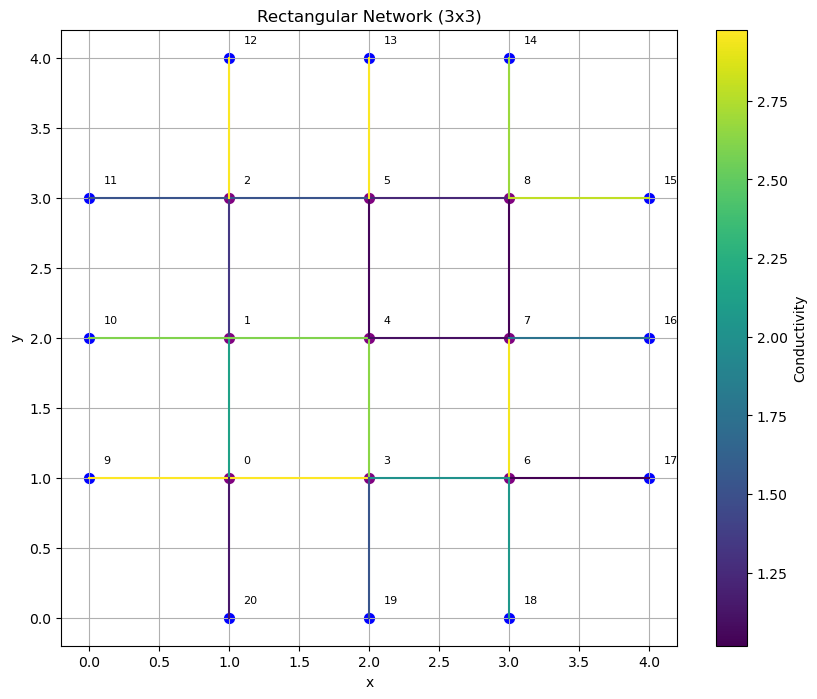

In [108]:
#this creates a rectangular grid of size 4 by 4 where the number of internal nodes is 3^2=9
n = 3
gr_ = GridStructure(n)
#this initializes our model
model_ = SquareEITNN(gr_)
#To visualize the network
gr_.visualize_network()

In [110]:
## To see the dtn data used for training, we use generate_dtn_data function
data_ = generate_dtn_data(gr_,4*n)   #the batch size is 4n since there are 4n unique dtn data we need for training
data_

tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.7364, -0.3819, -0.0502, -0.0974,
         -0.0878, -0.0308, -0.0320, -0.0897, -0.0667, -0.1352, -0.2878, -0.4769],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.3819,  1.5544, -0.1288, -0.2499,
         -0.1547, -0.0417, -0.0433, -0.0955, -0.0478, -0.0970, -0.1669, -0.1469],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.0502, -0.1288,  1.1778, -0.6779,
         -0.1739, -0.0288, -0.0300, -0.0184, -0.0082, -0.0166, -0.0259, -0.0193],
        [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.0974, -0.2499, -0.6779,  1.6483,
         -0.3375, -0.0560, -0.0582, -0.0357, -0.0159, -0.0322, -0.0502, -0.0375],
        [ 0.0000,  0.000

To check whether the data is correct or not, what we can do is to sum the neumann currents for each value. In the above matrix, each row represents a DtN data. The first 4n columns represent the boundary voltages and the last 4n columns represent the boundary currents in response to the corresponding boundary voltages. Remember that a valid Neumann data is such that the sum of boundary currents is 0. It is because the grid itself doesnt have any voltage or current source so current entering the grid must equal current going outside the grid. So, we could select the last 4n columns and then sum over them to see if we have a proper value.

In [114]:
neu_data_ = data_[:,-4*n:]     #select the last 4n columns of dtn data
for i in neu_data_:
    print(i.sum())     #sum over every row

tensor(-4.4409e-16, dtype=torch.float64)
tensor(-3.3307e-16, dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(2.2204e-16, dtype=torch.float64)
tensor(-1.1102e-16, dtype=torch.float64)
tensor(2.7756e-16, dtype=torch.float64)
tensor(3.3307e-16, dtype=torch.float64)
tensor(2.2204e-16, dtype=torch.float64)
tensor(8.3267e-17, dtype=torch.float64)
tensor(6.1062e-16, dtype=torch.float64)
tensor(-2.7756e-16, dtype=torch.float64)
tensor(2.2204e-16, dtype=torch.float64)


The sum of boundary currents is very insignificant(most likely due to rounding error). In a separate code, I created a function that would also return me the current at interior nodes. I checked the current at each interior node and the currents out of each interior node were also of the order of -16 and -17 signifying that our system correctly solves the forward problem.

### Now the training loop

The parameters of the function below are
- num_epoch : number of times we wish to run the forward and backward pass. 
- dataloader: it just loads the data. Dataloader has a feature where we can choose to select only a small subset of data to train in each loop. If there are 10 million data in the dataset, we might wish to choose only 1000 per epoch. But in our case since the dataset is very small, dataloader loads all the data at once.
- optimizer is used to specify which type of gradient descent algorithm we would like to apply. Adam, SGD, Batch gradient descent and so on.
- model refers to the SquareEITNN class which consists of all our parameters
- alpha is the hyperparameter we use to calculate loss
- learning-rate is simply the learning rate
- grid is the square structure on which we are performing the calculation

At each loop, the function does the following:
- zeros all the gradients that are computed or might be stored for the trainable parameters using optimizer.zero_grad()
- passes our data (batch_x: Remember this is the full DtN data for our purposes) to the model and compute the output using output = model(batch_x)
- computes the loss after the forward pass
- Then we perform loss.backward() which instructs the pytorch framework to compute the gradients for all the trainable parameters
- Then we update the trainable parameters using optimizer.step. i.e Let's say that for simplicity.Beta gets transformed to Beta' and W1 gets transformed to W1'. This update happens with the optimizer we specified i.e. Adam, SGD, etc.
- Since only a sub section of the W2_dynamic is Beta, we need to symmetrize the matrix to ensure that W2_dynamic is symmetrized and satisfies all the constraints before the next loop.
- After every 5000 epochs, we decrease the learning rate
- After the training is done (after num_epochs number of loops), we extract W2 and relevant information from W2 and display them as conductivities

In [116]:
# from types import TracebackType

def train_model(num_epoch,dataloader, optimizer, model, alpha, learning_rate,grid):
    num_epochs = num_epoch
    min_loss = np.inf
    min_lr = learning_rate
    loss_record = []

    for epoch in range(num_epochs):
        for batch_x in dataloader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = loss_function(output,grid, alpha)
            # if loss<min_loss:
            #     min_loss = loss
            #     for param_group in optimizer.param_groups:
            #         min_lr = param_group['lr']
            if (epoch+1) % 10 == 0:
                loss_record.append(float(loss))        
            loss.backward()        
            optimizer.step()
            model.symmetrize_W2_after_training()
        if (epoch + 1) % 5000 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1
        # if (epoch + 1) % 4000 == 0:
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] *= 99

        if (epoch + 1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6e}')
            # print("Output = ",output)

    recovered_gamma = model.W2_dynamic.detach().numpy()
    estimated_conductivities = {}
    for edge in grid.edges:
        p_idx, q_idx = edge
        if p_idx >= grid.node_count - grid.n: #or q_idx >= grid.node_count - grid.n:
            continue
        estimated_conductivities[edge] = recovered_gamma[p_idx, q_idx]
    # print(estimated_conductivities)
    original_conductivities = copy.deepcopy(grid.conductivities)
    print("\nConductivity Comparison Table")
    print(f"{'Edge':>10} | {'Estimated':>12} | {'True':>12}")
    print("-" * 38)
    for edge in grid.edges:
        if edge in estimated_conductivities:
            est = estimated_conductivities[edge]
            true = original_conductivities[edge]
            print(f"{str(edge):>10} | {est.item():12.6f} | {true.item():12.6f}")



    demo_grid = GridStructure(n)
    demo_grid.conductivities = original_conductivities
    print("Original Conductivity")
    demo_grid.visualize_network()


    demo_grid2 = GridStructure(n)
    demo_grid2.conductivities = estimated_conductivities
    print("Recovered Conductivity")
    demo_grid2.visualize_network()
    return loss_record,estimated_conductivities



### We now train a sample model
You can change the grid size by changing the value of n.

In [142]:
n_ = 3
batch_size_ = 4*n
grid_ = GridStructure(n)
data_ = generate_dtn_data(grid, batch_size)
dataloader_ = DataLoader(data, batch_size=batch_size, shuffle=True)
model_ = SquareEITNN(grid)
alpha_ = 1

### But before we begin training, let's check whether the matrices W1 and Beta and so on are initialized as we expected. The matrices that perform the multiplication W1_dynamic and W2_dynamic are not initialized yet as they are initialized in the forward function. But since we initializeed  a model, we can check the other parameters.

Note that in W1_fixed_mask, True elements are untrainable whereas the False elements are trainable. The top left n^2 by 4n sub matrix is all False hence trainable. And those are the only elements initialized in W1.

In [144]:
model_.W1_fixed_mask

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True],
        [False, Fals

In [146]:
model_.W1

Parameter containing:
tensor([[-1.5961e+00,  1.7263e+00, -6.8226e-01,  5.1255e-02,  1.5979e+00,
         -1.9704e+00,  1.1928e+00,  4.4644e-01, -3.5853e-01, -1.1328e+00,
         -3.6563e-01, -6.7112e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-5.4302e-01, -8.0006e-01,  4.3965e-01, -1.6527e+00, -7.6370e-01,
          2.1365e+00, -4.8055e-01, -1.8725e+00,  1.0179e+00, -1.9881e-02,
          1.3540e+00, -2.7097e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 4.3078e-01,  4.8151e-01, -1.0636e-01, -3.5781e-01,  3.8277e-01,
         -9.0036e-01,  1.8226e+00,  5.5899e-02,  7.4025e-01, -1.8248e+00,
         -3.0573e+00,  9.6866e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.00

In [148]:
model_.W1_fixed

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

Let's check similarly Beta, W2-mask and W2-fixed
- Note that for the first n^2 rows there are at maximum 4 False elements per row. It is because there are 4 neighbors per node.  But for some rows there are less than 4. Why? Because we initialize and train only the top half and due to symmetricity, we do not need to train the symmetric counterparts. In model.W2_mask below, observe that there are only 3 False in the second row. Because the element in the second column of the first row is trainable. So we do not need to train the first element of the second row.

In [150]:
model_.W2_mask

tensor([[ True, False,  True, False,  True,  True,  True,  True,  True, False,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True],
        [ True,  True, False,  True, False,  True,  True,  True,  True,  True,
         False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True],
        [ True,  True,  True,  True,  True, False,  True,  True,  True,  True,
          True, False, False,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True],
        [ True,  True,  True,  True, False,  True, False,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True, False,
          True,  True,  True,  True,  

Notice that Beta is symmetric and satisfies the diagonal condition. The bottom right submatrix where we have all 1s is also ecoded.

In [152]:
model_.Beta

Parameter containing:
tensor([[-0.8091,  0.1902,  0.0000,  0.3866,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.1091,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.1232,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.1902, -2.2691,  0.3889,  0.0000,  0.7779,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.9121,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.0000,  0.3889, -1.0845,  0.0000,  0.0000,  0.1264,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.4504,  0.1188,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0

Model.W2_fixed doesnt have a proper structure at the diagonal elements because we only use it to symmetrize the W2_dynamic matrix once Beta is trained. Since it is the initial step, it actually does not matter what the elements are at this step. Because after the first loop, all the symmetry conditions are satisfied.

In [154]:
model_.W2_fixed

tensor([[-0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.1902, -0.1902,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.0000,  0.3889, -0.3889,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,

Now let's train a model. We use an inbuilt adam optimizer to train a model. beta1. beta2 and eps are just hyperparameters for Adam optimizer We copy the initializations that we did before to now properly start training the model.

In [159]:
n = 3
batch_size = 4*n
grid = GridStructure(n)
data = generate_dtn_data(grid, batch_size)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
model = SquareEITNN(grid)
alpha = 1
num_epochs =10000

Epoch [1000/10000], Loss: 4.388039e+02
Epoch [2000/10000], Loss: 2.918440e+02
Epoch [3000/10000], Loss: 1.989758e+02
Epoch [4000/10000], Loss: 1.342729e+02
Epoch [5000/10000], Loss: 8.979299e+01
Epoch [6000/10000], Loss: 8.628070e+01
Epoch [7000/10000], Loss: 8.290700e+01
Epoch [8000/10000], Loss: 7.965308e+01
Epoch [9000/10000], Loss: 7.626186e+01
Epoch [10000/10000], Loss: 7.315927e+01

Conductivity Comparison Table
      Edge |    Estimated |         True
--------------------------------------
    (0, 1) |     1.672950 |     2.137771
    (0, 3) |     0.826912 |     2.975587
    (0, 9) |     3.022513 |     2.975587
   (0, 20) |     2.624665 |     1.145108
    (1, 2) |     1.953633 |     1.340625
    (1, 4) |     2.547012 |     2.605040
   (1, 10) |     0.760032 |     2.605040
    (2, 5) |     1.001474 |     1.527099
   (2, 11) |     0.766192 |     1.527099
   (2, 12) |     0.853144 |     2.964029
    (3, 4) |     2.498762 |     2.631639
    (3, 6) |     0.824064 |     2.014436
   (3,

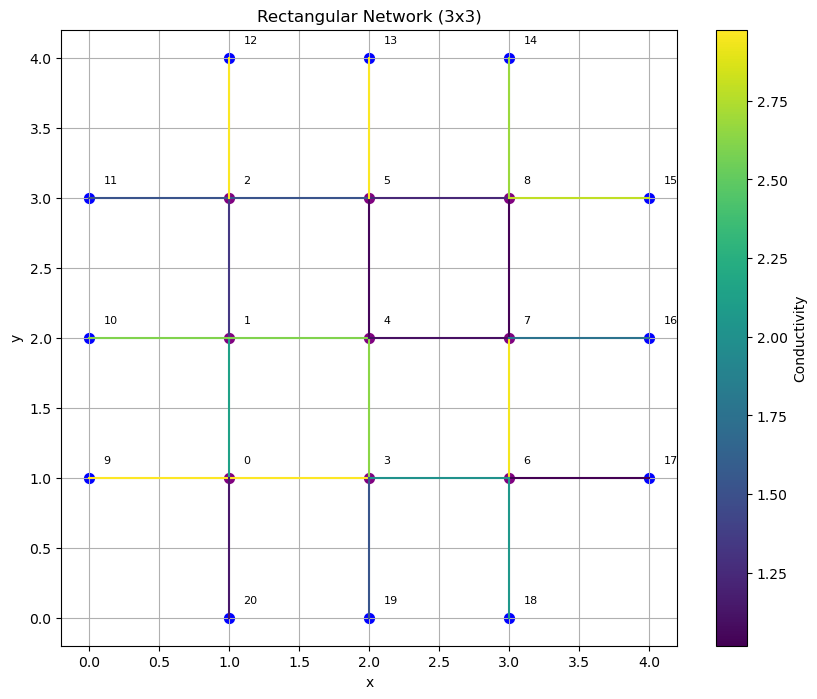

Recovered Conductivity


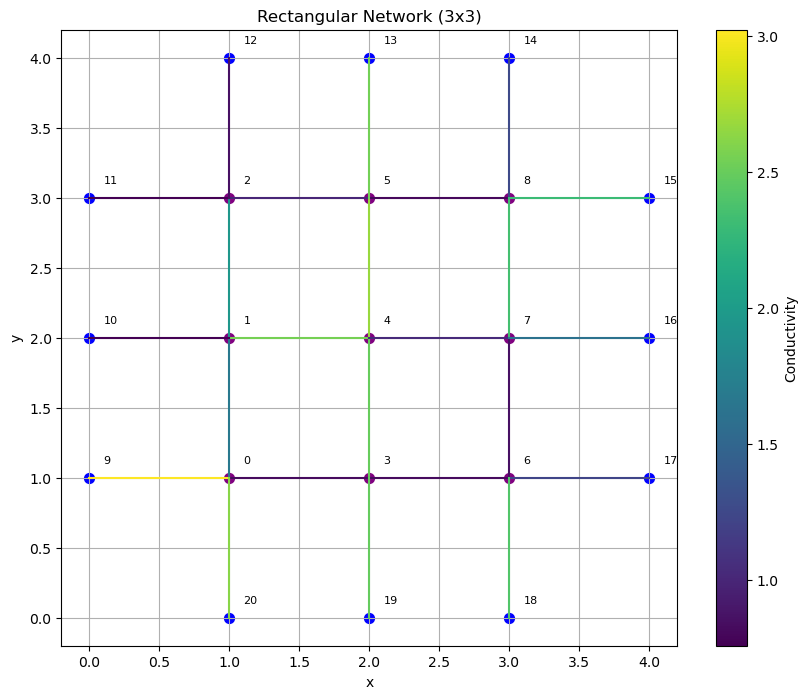

In [161]:

beta1 = 0.99
beta2 = 0.9
eps = 0.0000001
# optimizer = torch.optim.SGD(model.parameters(), lr=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, betas=(beta1, beta2), eps=eps)

l,est_conductivities = train_model(
            num_epoch=num_epochs,
            dataloader=dataloader,
            optimizer=optimizer,
            model=model,
            alpha=alpha,learning_rate = 0.0002,grid=grid 
        )

The loss does not converge properly, but let's just check if the structure of the matrices hold well. The matrices we check here are W1_dynamic and W2_dynamic. We could also check W1, Beta and so on, but those are just helper matrices. W1_dynamic and W2_dynamic are the matrices that perform the actual calcualtions.
- Observe that W1_dynamic has only trained elements in the top left half and the rest are 0s or 1s as we deduced from the paper.
 The rest of the elements are 0

In [164]:
model.W1_dynamic

tensor([[ 4.6080e-01, -3.4930e-02,  1.2834e-02,  5.8300e-01, -2.0658e-02,
         -4.8230e-01,  8.9341e-02, -6.7647e-01, -1.1513e-01,  2.4793e-01,
         -2.2529e-01,  2.5754e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 3.3001e-01, -1.7882e-01, -2.6549e-01,  2.2121e+00,  2.9187e-01,
         -1.7295e+00,  2.4481e-01, -1.9712e+00, -1.4491e-01,  1.2690e+00,
         -2.4099e-01, -3.6091e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-8.4234e-01, -2.1875e-01, -6.8464e-01,  5.3384e-02,  1.6356e-01,
         -7.5251e-01,  2.7453e-01, -1.5771e+00,  4.6959e-01,  1.0554e+00,
         -3.3549e-01, -9.4068e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  

In [166]:
model.W2_dynamic

tensor([[-8.1470,  1.6729,  0.0000,  0.8269,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  3.0225,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  2.6247,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 1.6729, -6.9336,  1.9536,  0.0000,  2.5470,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.7600,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.0000,  1.9536, -4.5744,  0.0000,  0.0000,  1.0015,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.7662,  0.8531,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,

Although I have been doing other tests too, this is the clean implementation of the core ideas mentioned in the paper. 